 # **Returns to Buying Winners and Selling Losers:**   
## **Implications for Stock Market Efficiency**
### by **JEGADEESH and TITMAN（1993）**

复制了论文中的表1，使用16种交易策略分析了1965年至1989年纽约证券交易所和美国证券交易所的股票，这些策略根据过去的回报选择股票，持有期从1到4个季度不等。

- 动量因子源自 Jegadeesh and Titman (1993) 提出的动量效应。
- 为了提高分析的统计能力，采用作者构建J月/K月策略的方法。
    - 在每月月末，依据**过去 J 个月**的股票总收益率排序，**将股票分为 10 组**，按照**等权重**方式做多收益率最高的组，同时做空收益率最低的组，并**持有 K 个月**。
    - 实证结果显示，无论是多空组合还是纯多头组合，都可以获取显著且稳健的超额收益。

## **数据预处理**

In [5]:
import pandas as pd
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import numpy as np 
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as mtick
from scipy.stats import ttest_1samp
from datetime import datetime
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文黑体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

In [6]:
# 导入CRSP数据
crsp = pd.read_csv('E:/Replications/MoM/1925-2018data.csv', dtype={'PERMNO': str})
cols_keep = ['PERMNO','date', 'SHRCD', 'EXCHCD', 'DLRET', 'PRC', 'RET', 'SHROUT']
crsp = crsp[cols_keep]
crsp.head()

,PERMNO,date,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT
0,10000,1985-12-31,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,1986-01-31,10.0,3.0,NaN,-4.3750,C,3680.0
2,10000,1986-02-28,10.0,3.0,NaN,-3.2500,-0.257143,3680.0
3,10000,1986-03-31,10.0,3.0,NaN,-4.4375,0.365385,3680.0
4,10000,1986-04-30,10.0,3.0,NaN,-4.0000,-0.098592,3793.0


In [7]:
# 筛选时间范围：1963-12 到 1991-01
crsp["date"] = pd.to_datetime(crsp["date"], errors='coerce')
start_date = '1963-12-01'
end_date = '1991-01-31'
mask_date = (crsp['date'] >= start_date) & (crsp['date'] <= end_date)

# 筛选普通股（SHRCD=10或11）+ NYSE 或 AMEX（EXCHCD=1或2）
mask_shrcd = crsp['SHRCD'].isin([10, 11])
mask_exchcd = crsp['EXCHCD'].isin([1, 2])
# 应用筛选条件
crsp = crsp[mask_date & mask_shrcd & mask_exchcd].copy()
crsp

,PERMNO,date,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT
1372,10006,1963-12-31,10.0,1.0,NaN,62.000,-0.004016,2948.0
1373,10006,1964-01-31,10.0,1.0,NaN,66.250,0.068548,2948.0
1374,10006,1964-02-28,10.0,1.0,NaN,68.750,0.043774,2948.0
1375,10006,1964-03-31,10.0,1.0,NaN,68.750,0.000000,2948.0
1376,10006,1964-04-30,10.0,1.0,NaN,69.000,0.003636,2948.0
...,...,...,...,...,...,...,...,...
4503172,93236,1990-09-28,11.0,2.0,NaN,13.500,-0.187970,2954.0
4503173,93236,1990-10-31,11.0,2.0,NaN,14.500,0.074074,2954.0
4503174,93236,1990-11-30,11.0,2.0,NaN,13.625,-0.060345,2954.0
4503175,93236,1990-12-31,11.0,2.0,NaN,11.250,-0.174312,3221.0


In [8]:
crsp.replace(["A", "S", "C", "T", "P"], np.nan, inplace = True)
crsp[["SHRCD", "EXCHCD", "SHROUT"]] = crsp[["SHRCD", "EXCHCD", "SHROUT"]].fillna(-99)
crsp[["PERMNO", "SHRCD", "EXCHCD", "SHROUT"]] = crsp[["PERMNO", "SHRCD", "EXCHCD", "SHROUT"]].astype(int)
crsp.replace([-99], np.nan, inplace = True)

In [9]:
# 转换收益为百分比:
crsp["RET"] = crsp["RET"].astype(float)
# 过滤掉缺失收益率、无意义的回报
crsp = crsp[crsp['RET'].notna()]
crsp = crsp[crsp['RET'] > -1]  # RET = -1 表示退市或其他极端负值（可视情况而定）
crsp = crsp.sort_values(by=['PERMNO', 'date']).reset_index(drop=True)
crsp.head()

,PERMNO,date,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT
0,10006,1963-12-31,10,1,NaN,62.00,-0.004016,2948.0
1,10006,1964-01-31,10,1,NaN,66.25,0.068548,2948.0
2,10006,1964-02-28,10,1,NaN,68.75,0.043774,2948.0
3,10006,1964-03-31,10,1,NaN,68.75,0.000000,2948.0
4,10006,1964-04-30,10,1,NaN,69.00,0.003636,2948.0


In [10]:
print(f"预处理后的样本共有 {crsp['PERMNO'].nunique()} 支股票，{len(crsp)} 条记录")
print(f"数据范围：{crsp['date'].min().date()} 至 {crsp['date'].max().date()}")

预处理后的样本共有 5024 支股票，710990 条记录
数据范围：1963-12-31 至 1991-01-31


In [11]:
crsp.head()

,PERMNO,date,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT
0,10006,1963-12-31,10,1,NaN,62.00,-0.004016,2948.0
1,10006,1964-01-31,10,1,NaN,66.25,0.068548,2948.0
2,10006,1964-02-28,10,1,NaN,68.75,0.043774,2948.0
3,10006,1964-03-31,10,1,NaN,68.75,0.000000,2948.0
4,10006,1964-04-30,10,1,NaN,69.00,0.003636,2948.0


## **错误计算**

### **计算累计回报(排序变量)**

In [14]:
crsp1 = crsp.copy()
# 先转为 log-return，便于累计计算（log(1 + r) 可加法累积）
crsp1["log_ret"] = np.log1p(crsp1["RET"])
# 滞后 log_ret 1 期，以跳过最近一个月（t-1）
crsp1["log_ret_lag1"] = crsp1.groupby("PERMNO")["log_ret"].shift(1)
# 计算形成期 log return 的 rolling sum：t-12 到 t-2（11 期）
crsp1["ranking_logret"] = crsp1.groupby("PERMNO")["log_ret_lag1"].transform(lambda x: x.rolling(window=11, min_periods=11).sum())
crsp1["Ranking_ret"] = np.expm1(crsp1["ranking_logret"])

In [15]:
# 删除指定的列
columns_to_drop = ['SHRCD', 'SHROUT', 'log_ret', 'log_ret_lag1', 'ranking_logret']
crsp1 = crsp1.drop(columns=[col for col in columns_to_drop if col in crsp1.columns])
crsp1

,PERMNO,date,EXCHCD,DLRET,PRC,RET,Ranking_ret
0,10006,1963-12-31,1,NaN,62.000,-0.004016,NaN
1,10006,1964-01-31,1,NaN,66.250,0.068548,NaN
2,10006,1964-02-28,1,NaN,68.750,0.043774,NaN
3,10006,1964-03-31,1,NaN,68.750,0.000000,NaN
4,10006,1964-04-30,1,NaN,69.000,0.003636,NaN
...,...,...,...,...,...,...,...
710985,93236,1990-09-28,2,NaN,13.500,-0.187970,NaN
710986,93236,1990-10-31,2,NaN,14.500,0.074074,NaN
710987,93236,1990-11-30,2,NaN,13.625,-0.060345,NaN
710988,93236,1990-12-31,2,NaN,11.250,-0.174312,NaN


### **每月根据累计收益排序并打分组标签（Decile）**
- 每月一次，根据 NYSE 股票形成分位数
- 所有股票都分组，但 仅使用 NYSE 股票决定分组边界

In [17]:
# 提取年份月份
crsp1["y_m"] = crsp1["date"].dt.to_period("M")

def assign_decile(df):
    df = df.copy()    
    non_missing = df[df["Ranking_ret"].notna()].copy()   
    nyse = non_missing[non_missing["EXCHCD"] == 1]
    
    if len(nyse) >= 10:
        # 计算 breakpoints
        breakpoints = np.percentile(nyse["Ranking_ret"], np.arange(10, 100, 10))
        # 分组赋值
        non_missing["decile"] = np.searchsorted(breakpoints, non_missing["Ranking_ret"]) + 1
    else:
        non_missing["decile"] = np.nan
    # 默认全设为 NaN（预分组列）
    df["decile"] = np.nan
    # 把非缺失且已成功打标签的合并回来
    df.loc[non_missing.index, "decile"] = non_missing["decile"]   
    return df

# 分组打标签（每月一次）
crsp1 = crsp1.groupby("y_m", group_keys = False).apply(assign_decile)
crsp1

,PERMNO,date,EXCHCD,DLRET,PRC,RET,Ranking_ret,y_m,decile
0,10006,1963-12-31,1,NaN,62.000,-0.004016,NaN,1963-12,NaN
1,10006,1964-01-31,1,NaN,66.250,0.068548,NaN,1964-01,NaN
2,10006,1964-02-28,1,NaN,68.750,0.043774,NaN,1964-02,NaN
3,10006,1964-03-31,1,NaN,68.750,0.000000,NaN,1964-03,NaN
4,10006,1964-04-30,1,NaN,69.000,0.003636,NaN,1964-04,NaN
...,...,...,...,...,...,...,...,...,...
710985,93236,1990-09-28,2,NaN,13.500,-0.187970,NaN,1990-09,NaN
710986,93236,1990-10-31,2,NaN,14.500,0.074074,NaN,1990-10,NaN
710987,93236,1990-11-30,2,NaN,13.625,-0.060345,NaN,1990-11,NaN
710988,93236,1990-12-31,2,NaN,11.250,-0.174312,NaN,1990-12,NaN


In [18]:
crsp2 = crsp1[["date", "PERMNO", "RET", "Ranking_ret", "decile", "y_m"]].dropna()
crsp2

,date,PERMNO,RET,Ranking_ret,decile,y_m
11,1964-11-30,10006,-0.023276,0.427353,9.0,1964-11
12,1964-12-31,10006,-0.056380,0.399751,9.0,1964-12
13,1965-01-29,10006,0.053459,0.236101,8.0,1965-01
14,1965-02-26,10006,-0.025970,0.247570,7.0,1965-02
15,1965-03-31,10006,0.040248,0.215171,7.0,1965-03
...,...,...,...,...,...,...
710977,1989-09-29,93201,0.035088,-0.329412,1.0,1989-09
710978,1989-10-31,93201,0.050847,-0.243589,1.0,1989-10
710979,1989-11-30,93201,0.209677,-0.060606,2.0,1989-11
710980,1989-12-29,93201,0.040000,0.293103,7.0,1989-12


In [19]:
print(crsp2['decile'].unique())

[ 9.  8.  7.  4.  3.  5.  6.  2. 10.  1.]


In [20]:
crsp2['decile'] = crsp2['decile'].astype(int)

In [21]:
# 选取某个月作为样例检查
sample_month = crsp2.loc[crsp2["y_m"] == "1985-06"]

# 分组统计
summary = (sample_month
           .groupby("decile", group_keys = False)["Ranking_ret"]
           .agg(["count", "mean", "min", "max"])
           .sort_index())
print(summary)

        count      mean       min       max
decile                                     
1         317 -0.362888 -0.835443 -0.178069
2         213 -0.093553 -0.178061 -0.021152
3         194  0.031199 -0.021080  0.080019
4         187  0.124842  0.080851  0.169230
5         179  0.210298  0.170031  0.250001
6         175  0.285003  0.250002  0.323529
7         172  0.366231  0.324324  0.405532
8         159  0.450089  0.405576  0.505438
9         170  0.572990  0.505922  0.646672
10        188  0.897951  0.647433  2.685641


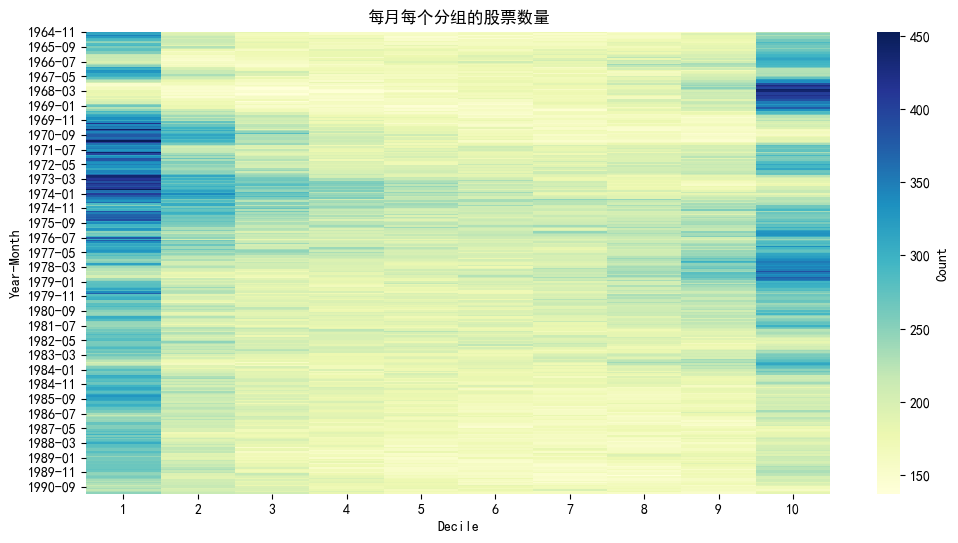

In [22]:
# 每月每组样本数
count_by_month = crsp2.groupby(["y_m", "decile"], group_keys = False).size().unstack()

# 可视化：热图
plt.figure(figsize=(12, 6))
sns.heatmap(count_by_month, cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.title("每月每个分组的股票数量")
plt.xlabel("Decile")
plt.ylabel("Year-Month")
plt.show()

In [23]:
# 查看某只股票近几个月的momentum_return和分组
crsp2.loc[crsp2["PERMNO"] == 10006, ["date", "Ranking_ret", "decile"]].tail(15)

,date,Ranking_ret,decile
231,1983-03-31,0.013402,2
232,1983-04-29,-0.048547,1
233,1983-05-31,0.091434,1
234,1983-06-30,0.165884,1
235,1983-07-29,0.305616,2
236,1983-08-31,0.161754,2
237,1983-09-30,0.054154,1
238,1983-10-31,0.720330,9
239,1983-11-30,0.602865,9
240,1983-12-30,0.636798,9


In [24]:
crsp2

,date,PERMNO,RET,Ranking_ret,decile,y_m
11,1964-11-30,10006,-0.023276,0.427353,9,1964-11
12,1964-12-31,10006,-0.056380,0.399751,9,1964-12
13,1965-01-29,10006,0.053459,0.236101,8,1965-01
14,1965-02-26,10006,-0.025970,0.247570,7,1965-02
15,1965-03-31,10006,0.040248,0.215171,7,1965-03
...,...,...,...,...,...,...
710977,1989-09-29,93201,0.035088,-0.329412,1,1989-09
710978,1989-10-31,93201,0.050847,-0.243589,1,1989-10
710979,1989-11-30,93201,0.209677,-0.060606,2,1989-11
710980,1989-12-29,93201,0.040000,0.293103,7,1989-12


### **Table 1**

In [26]:
start = '1965-01-01'
end = '1989-12-31'
# 筛选数据框
crsp2 = crsp2[(crsp2['date'] >= start) & (crsp2['date'] <= end)]
crsp2 = crsp2.sort_values(['PERMNO', 'date'])
crsp2.reset_index(drop = True)

,date,PERMNO,RET,Ranking_ret,decile,y_m
0,1965-01-29,10006,0.053459,0.236101,8,1965-01
1,1965-02-26,10006,-0.025970,0.247570,7,1965-02
2,1965-03-31,10006,0.040248,0.215171,7,1965-03
3,1965-04-30,10006,0.084821,0.259500,7,1965-04
4,1965-05-28,10006,-0.043621,0.381347,8,1965-05
...,...,...,...,...,...,...
629178,1989-08-31,93201,0.187500,-0.578947,1,1989-08
629179,1989-09-29,93201,0.035088,-0.329412,1,1989-09
629180,1989-10-31,93201,0.050847,-0.243589,1,1989-10
629181,1989-11-30,93201,0.209677,-0.060606,2,1989-11


In [27]:
# Step 1: 计算未来3个月的累积收益（假设RET为简单收益率）
def calc_forward_return(df, K=3):
    df = df.copy()
    df['RET_plus_1'] = df['RET'].shift(-1)
    df['RET_plus_2'] = df['RET'].shift(-2)
    df['RET_plus_3'] = df['RET'].shift(-3)
    df['RET_K3'] = (1 + df['RET']) * (1 + df['RET_plus_1']) * (1 + df['RET_plus_2']) - 1
    return df

# 对每只股票计算未来3个月收益
k3j3 = crsp2.groupby('PERMNO', group_keys=False).apply(calc_forward_return)
k3j3

,date,PERMNO,RET,Ranking_ret,decile,y_m,RET_plus_1,RET_plus_2,RET_plus_3,RET_K3
13,1965-01-29,10006,0.053459,0.236101,8,1965-01,-0.025970,0.040248,0.084821,0.067399
14,1965-02-26,10006,-0.025970,0.247570,7,1965-02,0.040248,0.084821,-0.043621,0.099176
15,1965-03-31,10006,0.040248,0.215171,7,1965-03,0.084821,-0.043621,-0.104348,0.079257
16,1965-04-30,10006,0.084821,0.259500,7,1965-04,-0.043621,-0.104348,0.009709,-0.070761
17,1965-05-28,10006,-0.043621,0.381347,8,1965-05,-0.104348,0.009709,0.059615,-0.135101
...,...,...,...,...,...,...,...,...,...,...
710976,1989-08-31,93201,0.187500,-0.578947,1,1989-08,0.035088,0.050847,0.209677,0.291666
710977,1989-09-29,93201,0.035088,-0.329412,1,1989-09,0.050847,0.209677,0.040000,0.315789
710978,1989-10-31,93201,0.050847,-0.243589,1,1989-10,0.209677,0.040000,NaN,0.322033
710979,1989-11-30,93201,0.209677,-0.060606,2,1989-11,0.040000,NaN,NaN,NaN


In [28]:
# 只保留当前月收益和分组
crsp_K3 = k3j3[['y_m', 'PERMNO', 'decile', 'RET_K3']].dropna()

# 分组取平均收益
avg_ret = crsp_K3.groupby(['y_m', 'decile'], group_keys = False)['RET_K3'].mean().unstack()

# 查看前几行看看是否合理
avg_ret.head()

decile,1,2,3,4,5,6,7,8,9,10
y_m,,,,,,,,,,
1965-01,0.197994,0.116776,0.110378,0.083792,0.098609,0.093907,0.108377,0.103482,0.111367,0.126249
1965-02,0.086971,0.106996,0.093057,0.072558,0.058387,0.062597,0.091275,0.094742,0.111043,0.111382
1965-03,0.049103,0.052993,0.033458,0.022109,0.043999,0.032859,0.043597,0.061776,0.070903,0.070154
1965-04,-0.080919,-0.047719,-0.036626,-0.036404,-0.046484,-0.045330,-0.049271,-0.023949,-0.054431,-0.061201
1965-05,-0.100421,-0.071172,-0.056512,-0.056478,-0.044007,-0.049829,-0.059843,-0.047855,-0.056354,-0.062653


In [29]:
# Buy: decile 10，Sell: decile 1
buy = avg_ret[10]
sell = avg_ret[1]
buy_sell = buy - sell

def mean_tstat(series):
    mu = series.mean()
    se = series.std(ddof=1) / np.sqrt(len(series))
    t = mu / se
    return mu, t

### **结果（错误）**

In [31]:
# 计算
buy_mu, buy_t = mean_tstat(buy)
sell_mu, sell_t = mean_tstat(sell)
bs_mu, bs_t = mean_tstat(buy_sell)

print("J=3, K=3:")
print(f"Sell: {sell_mu:.4f} ({sell_t:.2f})")
print(f"Buy : {buy_mu:.4f} ({buy_t:.2f})")
print(f"Buy-Sell: {bs_mu:.4f} ({bs_t:.2f})")

J=3, K=3:
Sell: 0.0217 (2.31)
Buy : 0.0570 (7.17)
Buy-Sell: 0.0353 (6.67)


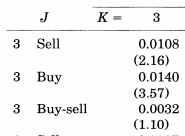

## **问题分析，每个J,K都要重新排序和分组，不能直接按照-2~-12来分组。**

## **正确计算，以 J = 3 为示例**

In [35]:
# 根据过去 J=3 个月的回报来排序
# 过去3个月的复利收益
crspJK = crsp.copy()
crspJK["Ranking_JK"] = crspJK.groupby("PERMNO", group_keys = False)["RET"].transform(
    lambda x: (1 + x.shift(1)).rolling(3).apply(np.prod, raw=True) - 1)
crspJK

,PERMNO,date,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT,Ranking_JK
0,10006,1963-12-31,10,1,NaN,62.000,-0.004016,2948.0,NaN
1,10006,1964-01-31,10,1,NaN,66.250,0.068548,2948.0,NaN
2,10006,1964-02-28,10,1,NaN,68.750,0.043774,2948.0,NaN
3,10006,1964-03-31,10,1,NaN,68.750,0.000000,2948.0,0.110843
4,10006,1964-04-30,10,1,NaN,69.000,0.003636,2948.0,0.115323
...,...,...,...,...,...,...,...,...,...
710985,93236,1990-09-28,11,2,NaN,13.500,-0.187970,2954.0,-0.022058
710986,93236,1990-10-31,11,2,NaN,14.500,0.074074,2954.0,-0.250000
710987,93236,1990-11-30,11,2,NaN,13.625,-0.060345,2954.0,-0.216216
710988,93236,1990-12-31,11,2,NaN,11.250,-0.174312,3221.0,-0.180451


In [36]:
# 形成十个等权重组合：分组为decile 1到10
# 每月进行分组
crspJK["y_m"] = crspJK["date"].dt.to_period("M")
crspJK["decile"] = crspJK.groupby("y_m", group_keys = False)["Ranking_JK"].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)
crspJK

,PERMNO,date,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT,Ranking_JK,y_m,decile
0,10006,1963-12-31,10,1,NaN,62.000,-0.004016,2948.0,NaN,1963-12,NaN
1,10006,1964-01-31,10,1,NaN,66.250,0.068548,2948.0,NaN,1964-01,NaN
2,10006,1964-02-28,10,1,NaN,68.750,0.043774,2948.0,NaN,1964-02,NaN
3,10006,1964-03-31,10,1,NaN,68.750,0.000000,2948.0,0.110843,1964-03,8.0
4,10006,1964-04-30,10,1,NaN,69.000,0.003636,2948.0,0.115323,1964-04,7.0
...,...,...,...,...,...,...,...,...,...,...,...
710985,93236,1990-09-28,11,2,NaN,13.500,-0.187970,2954.0,-0.022058,1990-09,9.0
710986,93236,1990-10-31,11,2,NaN,14.500,0.074074,2954.0,-0.250000,1990-10,5.0
710987,93236,1990-11-30,11,2,NaN,13.625,-0.060345,2954.0,-0.216216,1990-11,6.0
710988,93236,1990-12-31,11,2,NaN,11.250,-0.174312,3221.0,-0.180451,1990-12,4.0


**持有期 K=3，并每月重建组合” + “使用滚动重叠的持有**  
- **意思**：不仅持有当前月构建的组合，还要继续持有上月和上上月构建的组合，每个组合持有 3 个月 → 每个月组合是 K 期组合的平均！
- 举例：在 1980-01 月，K = 3 意味着我们持有：  
    - 1980-01 当月建的组合（第1个月）  
    - 1979-12 月建的组合（第2个月）  
    - 1979-11 月建的组合（第3个月）

这三个组合 **按等权重合并**，构成我们在1980-01的投资。

In [38]:
# 记录每个月形成的组合，以及它们在未来3个月的收益
# 抽取每月建仓的股票与分组信息
formation_df = crspJK[["date", "y_m", "PERMNO", "decile", "RET"]].copy()
formation_df = formation_df.dropna(subset=["decile"])

# 建立一个“持有记录表”：每个组合持有未来3个月
holding_frames = []
for lag in range(3):
    temp = formation_df.copy()
    temp["holding_month"] = temp["y_m"] + lag  # pd.Period
    temp["lag_index"] = lag
    holding_frames.append(temp)

holding_df = pd.concat(holding_frames)

- 这段代码的主要目的是为每个股票构建一个持有记录表，其中每个股票在形成期（y_m）后被持有 3 个月（包括形成期当月）。
- 通过循环和偏移量 lag，生成未来 3 个月的持有期记录，并将这些记录合并到一个新的数据框 holding_df 中

In [40]:
# 将 crspJK 的实际收益拼到 holding 表中
ret_df = crspJK[["y_m", "PERMNO", "RET"]].rename(columns={"y_m": "holding_month"})
merged = pd.merge(holding_df, ret_df, on=["holding_month", "PERMNO"], how="left", suffixes=("", "_actual"))
# 每月每组的等权平均收益
monthly_group_ret = merged.groupby(["holding_month", "decile"], group_keys = False)["RET_actual"].mean().unstack()
monthly_group_ret

decile,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
holding_month,,,,,,,,,,
1964-03,0.004064,0.022421,0.038480,0.022734,0.023228,0.039852,0.030279,0.030521,0.032862,0.023171
1964-04,-0.012907,-0.008742,0.005670,0.008541,0.010137,0.006274,0.007135,-0.004437,-0.011010,0.002809
1964-05,-0.021139,0.001850,0.008290,0.004287,0.010365,0.012389,0.013149,0.011940,0.016690,0.015804
1964-06,0.001243,0.007512,0.011874,0.012548,0.015820,0.013434,0.015039,0.013278,0.010538,0.010479
1964-07,0.023913,0.028135,0.029755,0.028872,0.033244,0.033841,0.033157,0.030565,0.027077,0.030363
...,...,...,...,...,...,...,...,...,...,...
1990-11,0.089189,0.088621,0.070907,0.073384,0.068319,0.059734,0.070062,0.042687,0.027901,0.015207
1990-12,-0.066061,0.007481,0.015943,0.021122,0.018476,0.021208,0.022779,0.025948,0.018822,-0.007014
1991-01,0.291792,0.133015,0.111576,0.104875,0.084719,0.084556,0.086121,0.051552,0.039579,0.070096


In [41]:
print(monthly_group_ret.index)

PeriodIndex(['1964-03', '1964-04', '1964-05', '1964-06', '1964-07', '1964-08',
             '1964-09', '1964-10', '1964-11', '1964-12',
             ...
             '1990-06', '1990-07', '1990-08', '1990-09', '1990-10', '1990-11',
             '1990-12', '1991-01', '1991-02', '1991-03'],
            dtype='period[M]', name='holding_month', length=325)


In [42]:
# 字符串形式
filtered = monthly_group_ret.loc["1965-01":"1989-12"]
filtered

decile,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
holding_month,,,,,,,,,,
1965-01,0.114504,0.080687,0.078232,0.069179,0.058721,0.062249,0.064461,0.056922,0.065819,0.071066
1965-02,0.034561,0.034653,0.041039,0.030081,0.031114,0.037364,0.029393,0.025710,0.041673,0.032657
1965-03,0.031376,0.019634,0.013998,0.018385,0.015951,0.015070,0.008270,0.010609,0.012137,0.007722
1965-04,0.034749,0.035231,0.040036,0.041814,0.033831,0.036145,0.043631,0.052954,0.051973,0.053210
1965-05,-0.015906,-0.006193,-0.008004,-0.005956,-0.003455,-0.004477,-0.006766,-0.008100,-0.001321,-0.001351
...,...,...,...,...,...,...,...,...,...,...
1989-08,-0.008979,0.019792,0.028209,0.026528,0.029600,0.024511,0.014154,0.014548,0.029921,0.014772
1989-09,-0.022830,-0.015985,-0.009926,0.003827,-0.006835,-0.003484,-0.002332,0.002492,0.004550,-0.004751
1989-10,-0.110975,-0.084276,-0.059370,-0.068316,-0.044204,-0.046071,-0.040011,-0.041869,-0.055166,-0.074020


In [43]:
# 提取 decile 1、10
sell = filtered[1]
buy = filtered[10]
buy_sell = buy - sell

# 汇总结果
def mean_t(series):
    series = series.dropna()
    mean = series.mean()
    std_err = series.std(ddof=1) / np.sqrt(len(series))
    t_val = mean / std_err
    return mean, t_val

sell_mu, sell_t = mean_t(sell)
buy_mu, buy_t = mean_t(buy)
bs_mu, bs_t = mean_t(buy_sell)

print("J=3, K=3 结果（等权平均）")
print(f"Sell组合（第1组）: {sell_mu:.3f}")
print(f"Buy组合（第10组）: {buy_mu:.3f}")
print(f"Buy - Sell组合差: {bs_mu:.3f}")

J=3, K=3 结果（等权平均）
Sell组合（第1组）: 0.011
Buy组合（第10组）: 0.013
Buy - Sell组合差: 0.002


#### **原文结果**
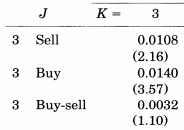

#### Sell组合结果**相差0.06%**，Buy组合结果**相差0.06%**，Buy-Sell(高减低)组合结果**相差0.12%。**

## **封装形成期 + 持有期收益函数**
将刚才的代码稍微封装一下，以便反复调用：

In [47]:
def run_momentum_panelA_JK(df, J, K):
    # 形成期动量（J=3/6/9/12）
    df = df.sort_values(["PERMNO", "date"])
    # 为每只股票计算过去 J 个月（滞后1期，即不含当月）的累积收益，用于后续排序。
    df["mom"] = df.groupby("PERMNO", group_keys = False)["RET"].transform(lambda x: (1 + x.shift(1)).rolling(J).apply(np.prod, raw=True) - 1)
    df["decile"] = df.groupby("y_m")["mom"].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates="drop") + 1)
    formation_df = df[["date", "y_m", "PERMNO", "decile", "RET"]].dropna()

    holding_frames = []
    for lag in range(K):
        temp = formation_df.copy()
        # 每份向前平移 lag 个月，构造滚动的持有期组合
        temp["holding_month"] = temp["y_m"] + lag
        holding_frames.append(temp)
    # 最终 holding_df 表示每个月要持有哪些股票（每个 J-K 策略都持有 K 个月）
    holding_df = pd.concat(holding_frames)

    # 拼接未来收益
    ret_df = df[["y_m", "PERMNO", "RET"]].rename(columns={"y_m": "holding_month"})
    merged = pd.merge(holding_df, ret_df, on=["holding_month", "PERMNO"], how="left", suffixes=("", "_actual"))
    # 计算 decile 1、10 和 Buy-Sell 平均收益
    monthly_group_ret = merged.groupby(["holding_month", "decile"])["RET_actual"].mean().unstack()
    filtered = monthly_group_ret.loc["1965-01":"1989-12"]
    sell = filtered[1]
    buy = filtered[10]
    buy_sell = buy - sell

    # 汇总收益和 t 值    
    def mean_t(series):
        series = series.dropna()
        mean = series.mean()
        std_err = series.std(ddof=1) / np.sqrt(len(series))
        t_val = mean / std_err
        return mean, t_val

    sell_mu, sell_t = mean_t(sell)
    buy_mu, buy_t = mean_t(buy)
    bs_mu, bs_t = mean_t(buy_sell)

    return {"K": K, "Sell": (sell_mu, sell_t), "Buy": (buy_mu, buy_t), "Buy-Sell": (bs_mu, bs_t)}

运行之后，将得到每个 K 下的 Sell、Buy、Buy-Sell 收益和 t 值。

In [49]:
# 运行 Panel A 的 J=3/6/9/12
results_panelA_J3 = []
results_panelA_J6 = []
results_panelA_J9 = []
results_panelA_J12 = []

for K in [3, 6, 9, 12]:
    results_panelA_J3.append(run_momentum_panelA_JK(crspJK, J=3, K=K))
    results_panelA_J6.append(run_momentum_panelA_JK(crspJK, J=6, K=K))
    results_panelA_J9.append(run_momentum_panelA_JK(crspJK, J=9, K=K))
    results_panelA_J12.append(run_momentum_panelA_JK(crspJK, J=12, K=K))

In [50]:
# 制表
def format_panelA_row(results_J):
    return pd.DataFrame({
        "K=3": [f"{results_J[0]['Sell'][0]:.3f} ({results_J[0]['Sell'][1]:.2f})",
                f"{results_J[0]['Buy'][0]:.3f} ({results_J[0]['Buy'][1]:.2f})",
                f"{results_J[0]['Buy-Sell'][0]:.3f} ({results_J[0]['Buy-Sell'][1]:.2f})"],
        "K=6": [f"{results_J[1]['Sell'][0]:.3f} ({results_J[1]['Sell'][1]:.2f})",
                f"{results_J[1]['Buy'][0]:.3f} ({results_J[1]['Buy'][1]:.2f})",
                f"{results_J[1]['Buy-Sell'][0]:.3f} ({results_J[1]['Buy-Sell'][1]:.2f})"],
        "K=9": [f"{results_J[2]['Sell'][0]:.3f} ({results_J[2]['Sell'][1]:.2f})",
                f"{results_J[2]['Buy'][0]:.3f} ({results_J[2]['Buy'][1]:.2f})",
                f"{results_J[2]['Buy-Sell'][0]:.3f} ({results_J[2]['Buy-Sell'][1]:.2f})"],
        "K=12": [f"{results_J[3]['Sell'][0]:.3f} ({results_J[3]['Sell'][1]:.2f})",
                 f"{results_J[3]['Buy'][0]:.3f} ({results_J[3]['Buy'][1]:.2f})",
                 f"{results_J[3]['Buy-Sell'][0]:.3f} ({results_J[3]['Buy-Sell'][1]:.2f})"]
    }, index=["Sell", "Buy", "Buy-Sell"])

In [51]:
# 调用函数制表
panelA_J3 = format_panelA_row(results_panelA_J3)
panelA_J6 = format_panelA_row(results_panelA_J6)
panelA_J9 = format_panelA_row(results_panelA_J9)
panelA_J12 = format_panelA_row(results_panelA_J12)

## **Panel A 汇总**

In [53]:
# 给每个表加上索引表示 J 值
panelA_J3.index = pd.MultiIndex.from_product([[3], panelA_J3.index], names=["J", "Strategy"])
panelA_J6.index = pd.MultiIndex.from_product([[6], panelA_J6.index], names=["J", "Strategy"])
panelA_J9.index = pd.MultiIndex.from_product([[9], panelA_J9.index], names=["J", "Strategy"])
panelA_J12.index = pd.MultiIndex.from_product([[12], panelA_J12.index], names=["J", "Strategy"])

# 合并四个部分
panelA_full = pd.concat([panelA_J3, panelA_J6, panelA_J9, panelA_J12])
panelA_full

K=3           K=6           K=9          K=12
J  Strategy                                                        
3  Sell      0.011 (2.27)  0.009 (1.95)  0.009 (1.99)  0.009 (1.92)
   Buy       0.013 (3.42)  0.014 (3.65)  0.015 (3.71)  0.015 (3.79)
   Buy-Sell  0.002 (0.72)  0.005 (2.05)  0.005 (2.47)  0.006 (3.38)
6  Sell      0.010 (1.86)  0.009 (1.69)  0.008 (1.60)  0.008 (1.75)
   Buy       0.016 (4.10)  0.017 (4.20)  0.017 (4.22)  0.016 (4.06)
   Buy-Sell  0.007 (1.96)  0.008 (2.77)  0.009 (3.55)  0.008 (3.18)
9  Sell      0.009 (1.69)  0.007 (1.43)  0.008 (1.55)  0.009 (1.75)
   Buy       0.018 (4.42)  0.018 (4.44)  0.017 (4.22)  0.016 (3.99)
   Buy-Sell  0.009 (2.55)  0.011 (3.54)  0.010 (3.26)  0.008 (2.73)
12 Sell      0.007 (1.39)  0.007 (1.45)  0.008 (1.60)  0.009 (1.82)
   Buy       0.019 (4.56)  0.018 (4.31)  0.017 (4.09)  0.016 (3.83)
   Buy-Sell  0.012 (3.39)  0.010 (3.17)  0.009 (2.78)  0.006 (2.15)

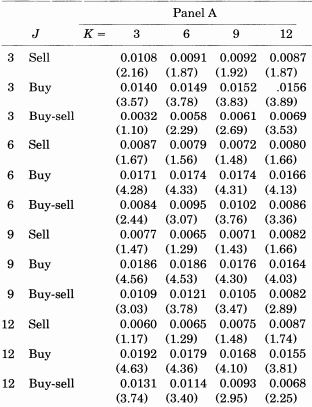

#### **这里结果与原文的差异均在0.04% ~ 0.1%之间。**

#### **差异潜在原因**
**1. 原文使用的是“日度复利生成的月度回报”**  
- 文章使用的CRSP每日回报文件在本研究开始时涵盖了1962年7月至1989年12月的期间。通过将该数据集中记录的每日回报进行复利计算，获得了每月回报。
- 使用日度复利得到的月度收益更接近真实交易回报；而月度 RET 变量可能有估值跳动、未调整的问题；在排序分组、累积收益乘积的计算上，这种微小差异会放大。

**2. 文章没有提到数据处理的细节**
- 仅仅包含筛选交易所/普通股
- 过滤掉缺失收益率、无意义的回报


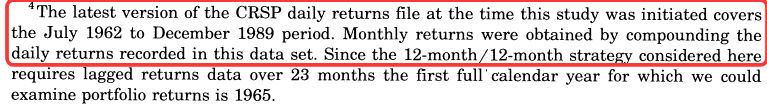

## **Panel B 封装函数**
- 技术实现方式：跳过建仓延迟一周（我们按月数据实现）
- **原文说的是“跳过一周”，由于我的是月度数据**，所以我采用的做法是：
    - **将形成期 t−J ~ t−1 的排序分组，延迟一个月，在 t+1 月建仓**。

### **Panel B 实现步骤**
1. 使用 t−J ~ t−1 的收益构造排序变量（momentum）
2. 将排序结果对应的分组 decile 移动到下一个月建仓（滞后1月）  
3. 再用与 Panel A 相同的方式做多期持有与收益计算

In [57]:
def run_momentum_panelB_JK(df1, J, K):
    df1 = df1.sort_values(["PERMNO", "date"])
    df1["mom"] = df1.groupby("PERMNO")["RET"].transform(lambda x: (1 + x.shift(1)).rolling(J).apply(np.prod, raw=True) - 1)
    df1["raw_decile"] = df1.groupby("y_m")["mom"].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates="drop") + 1)
    # 将 decile 滞后一个月（即延迟建仓）
    df1["y_m_lagged"] = df1["y_m"] + 1  # Period加1月
    df1["decile"] = df1.groupby("PERMNO")["raw_decile"].shift(1)

    # 构建持仓信息
    formation_df = df1[["y_m", "y_m_lagged", "PERMNO", "decile", "RET"]].dropna()
    formation_df["formation_month"] = formation_df["y_m_lagged"]

    holding_frames = []
    for lag in range(K):
        temp = formation_df.copy()
        temp["holding_month"] = temp["formation_month"] + lag
        holding_frames.append(temp)

    holding_df = pd.concat(holding_frames)

    ret_df = df1[["y_m", "PERMNO", "RET"]].rename(columns={"y_m": "holding_month"})
    merged = pd.merge(holding_df, ret_df, on=["holding_month", "PERMNO"], how="left", suffixes=("", "_actual"))
    monthly_group_ret = merged.groupby(["holding_month", "decile"])["RET_actual"].mean().unstack()
    filtered = monthly_group_ret.loc["1965-01":"1989-12"]
    sell = filtered[1]
    buy = filtered[10]
    buy_sell = buy - sell

    def mean_t(series):
        series = series.dropna()
        mean = series.mean()
        std_err = series.std(ddof=1) / np.sqrt(len(series))
        t_val = mean / std_err
        return mean, t_val

    sell_mu, sell_t = mean_t(sell)
    buy_mu, buy_t = mean_t(buy)
    bs_mu, bs_t = mean_t(buy_sell)

    #print(f"J=3, K={K} 结果：")
    #print(f"Sell组合（第1组）: {sell_mu:.3f} ({sell_t:.2f})")
    #print(f"Buy组合（第10组）: {buy_mu:.3f} ({buy_t:.2f})")
    #print(f"Buy - Sell组合差: {bs_mu:.3f} ({bs_t:.2f})")

    return {"K": K, "Sell": (sell_mu, sell_t), "Buy": (buy_mu, buy_t), "Buy-Sell": (bs_mu, bs_t)}

In [58]:
# 制表
def format_panelB_row(results_J):
    return pd.DataFrame({
        "K=3": [f"{results_J[0]['Sell'][0]:.3f} ({results_J[0]['Sell'][1]:.2f})",
                f"{results_J[0]['Buy'][0]:.3f} ({results_J[0]['Buy'][1]:.2f})",
                f"{results_J[0]['Buy-Sell'][0]:.3f} ({results_J[0]['Buy-Sell'][1]:.2f})"],
        "K=6": [f"{results_J[1]['Sell'][0]:.3f} ({results_J[1]['Sell'][1]:.2f})",
                f"{results_J[1]['Buy'][0]:.3f} ({results_J[1]['Buy'][1]:.2f})",
                f"{results_J[1]['Buy-Sell'][0]:.3f} ({results_J[1]['Buy-Sell'][1]:.2f})"],
        "K=9": [f"{results_J[2]['Sell'][0]:.3f} ({results_J[2]['Sell'][1]:.2f})",
                f"{results_J[2]['Buy'][0]:.3f} ({results_J[2]['Buy'][1]:.2f})",
                f"{results_J[2]['Buy-Sell'][0]:.3f} ({results_J[2]['Buy-Sell'][1]:.2f})"],
        "K=12": [f"{results_J[3]['Sell'][0]:.3f} ({results_J[3]['Sell'][1]:.2f})",
                 f"{results_J[3]['Buy'][0]:.3f} ({results_J[3]['Buy'][1]:.2f})",
                 f"{results_J[3]['Buy-Sell'][0]:.3f} ({results_J[3]['Buy-Sell'][1]:.2f})"]
    }, index=["Sell", "Buy", "Buy-Sell"])

## **Panel B 汇总**

In [60]:
# 运行 Panel B 的 J=3/6/9/12
results_panelB_J3 = []
results_panelB_J6 = []
results_panelB_J9 = []
results_panelB_J12 = []

for K in [3, 6, 9, 12]:
    results_panelB_J3.append(run_momentum_panelB_JK(crspJK, J=3, K=K))
    results_panelB_J6.append(run_momentum_panelB_JK(crspJK, J=6, K=K))
    results_panelB_J9.append(run_momentum_panelB_JK(crspJK, J=9, K=K))
    results_panelB_J12.append(run_momentum_panelB_JK(crspJK, J=12, K=K))

# 调用函数制表
panelB_J3 = format_panelB_row(results_panelB_J3)
panelB_J6 = format_panelB_row(results_panelB_J6)
panelB_J9 = format_panelB_row(results_panelB_J9)
panelB_J12 = format_panelB_row(results_panelB_J12)

In [61]:
# 加上多重索引并合并所有 J 组
panelB_J3.index = pd.MultiIndex.from_product([[3], panelB_J3.index], names=["J", "Strategy"])
panelB_J6.index = pd.MultiIndex.from_product([[6], panelB_J6.index], names=["J", "Strategy"])
panelB_J9.index = pd.MultiIndex.from_product([[9], panelB_J9.index], names=["J", "Strategy"])
panelB_J12.index = pd.MultiIndex.from_product([[12], panelB_J12.index], names=["J", "Strategy"])

# 合并成完整 Panel B 表格
panelB_full = pd.concat([panelB_J3, panelB_J6, panelB_J9, panelB_J12])
panelB_full

K=3           K=6           K=9          K=12
J  Strategy                                                        
3  Sell      0.007 (1.42)  0.008 (1.71)  0.008 (1.68)  0.009 (1.97)
   Buy       0.016 (3.96)  0.016 (3.89)  0.016 (3.94)  0.015 (3.78)
   Buy-Sell  0.009 (3.61)  0.008 (3.48)  0.008 (4.63)  0.006 (3.45)
6  Sell      0.007 (1.31)  0.007 (1.37)  0.007 (1.56)  0.009 (1.87)
   Buy       0.017 (4.27)  0.018 (4.30)  0.017 (4.13)  0.016 (3.83)
   Buy-Sell  0.011 (3.60)  0.011 (4.35)  0.010 (3.96)  0.007 (2.79)
9  Sell      0.005 (1.01)  0.007 (1.33)  0.008 (1.59)  0.009 (1.91)
   Buy       0.019 (4.55)  0.018 (4.26)  0.016 (3.99)  0.015 (3.69)
   Buy-Sell  0.014 (4.73)  0.011 (3.93)  0.009 (3.18)  0.006 (2.14)
12 Sell      0.006 (1.23)  0.007 (1.46)  0.009 (1.71)  0.010 (1.98)
   Buy       0.017 (4.19)  0.016 (3.94)  0.015 (3.69)  0.014 (3.45)
   Buy-Sell  0.011 (3.39)  0.009 (2.85)  0.007 (2.20)  0.004 (1.45)

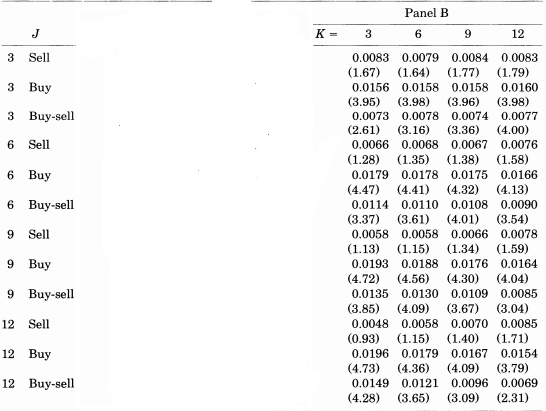

## **两个面板的对比**

| 表格         | Panel A                                                                 | Panel B                                                                 |
|--------------|-------------------------------------------------------------------------|-------------------------------------------------------------------------|
| 组合形成时机 | 用形成期收益 t-j 到 t-1 排序后，在 t 当月建仓                           | 用同样形成期收益排序，跳过一周后才建仓                                 |
| 核心操作     | 排序后立即建仓                                                          | 排序后推迟建仓（约为下月初）                                           |
| 目的         | 反映纯粹动量效应                                                        | 排除短期价格反转、公告反应、交易摩擦的干扰                            |

## **绘图分析**

### **图1：动量策略（Buy-Sell）收益随 K 增长变化（每个 J）**
绘制 每个 J 下，Buy-Sell 的年化收益随 K 的变化曲线，这样非常直观地看出动量收益是否随持有期变化增强或减弱。

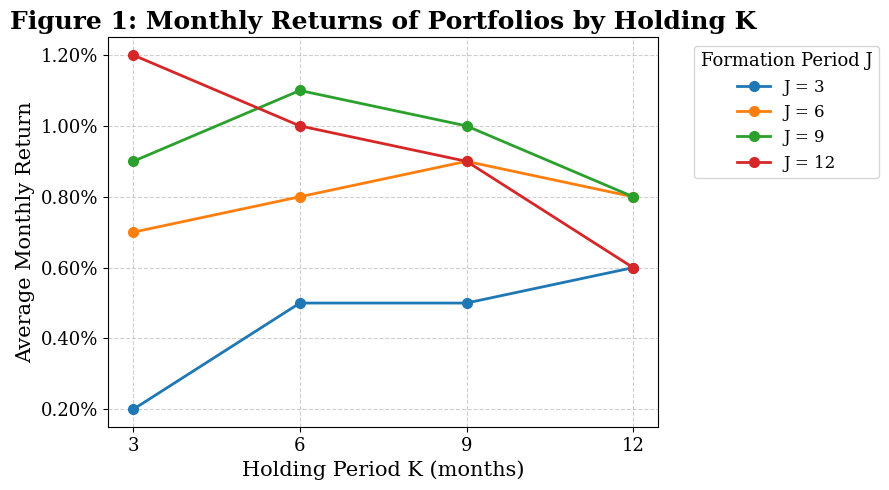

In [66]:
# 提取 Buy-Sell 收益矩阵
buy_sell_mat = panelA_full.xs("Buy-Sell", level="Strategy")
buy_sell_vals = buy_sell_mat.applymap(lambda x: float(x.split(" ")[0]))  # 只取收益数值部分
# 设置字体风格为 serif
plt.rcParams['font.family'] = 'serif'

# 绘图
plt.figure(figsize=(9, 5))
for j in buy_sell_vals.index:
    plt.plot([3, 6, 9, 12], buy_sell_vals.loc[j], marker = "o", markersize = 7, linewidth = 2, label=f"J = {j}")

plt.title("Figure 1: Monthly Returns of Portfolios by Holding K", fontsize=18, fontweight='bold')
plt.xlabel("Holding Period K (months)", fontsize=15)
plt.ylabel("Average Monthly Return", fontsize=15)

# 百分比坐标轴（格式化为 %）
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
# 坐标轴刻度
plt.xticks([3, 6, 9, 12], fontsize=13)
plt.yticks(fontsize=13)

# 图例
plt.legend(title="Formation Period J", fontsize=12, title_fontsize=13, bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**图1：**
- 横轴（K）：表示持有期长度（3, 6, 9, 12 个月）。
- 纵轴（收益率）：对应不同 J（形成期）和 K（持有期）组合下的 Buy-Sell 平均月收益率。
- 图中各条线：代表不同形成期 J（3、6、9、12 个月）。

**观察与分析：**
**1. J 越长，初始 Buy-Sell 收益率越高（尤其在 K=3 时）**：  
J=12 时，K=3 有最高的收益率（1.2%），明显优于其他组合。  
这说明长期动量（如过去一年收益）在短期持有下最有效。  

**2. J=3（短期动量）策略的表现最弱**：  
所有持有期下，J=3 的 Buy-Sell 收益都最低，并呈上升趋势，说明短期动量信号较弱，或需较长时间兑现。  

**3. J=6 或 J=9 表现稳定**：  
Buy-Sell 收益率在中等水平，且在持有期较短（K=6 或 K=9）时表现最好。   
表明中期动量策略（6–9 月）具备一定的可持续性和稳定性。   

**4. 大部分线条在 K=9 或 K=12 后下滑**：  
收益率在持有时间过长时下降，说明动量效应可能会随时间衰减，不建议过长持有。

### **图2：热力图：不同 J-K 下的 Buy-Sell 收益率**

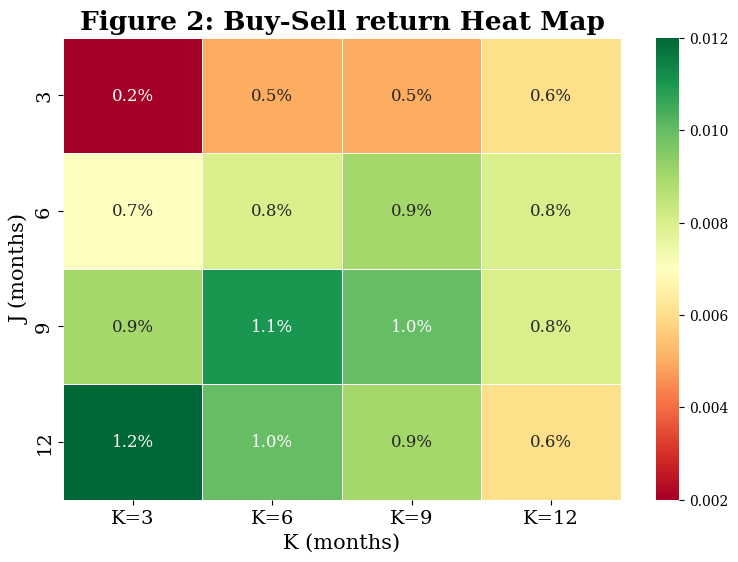

In [69]:
# 构建 Buy-Sell 收益 DataFrame，行为 J，列为 K
heat_data = buy_sell_vals.copy()
heat_data.index.name = "J"
plt.rcParams['font.family'] = 'serif'

# 创建热力图
plt.figure(figsize=(9, 6))
sns.heatmap(heat_data, annot=True, cmap="RdYlGn", fmt=".1%", linewidths=0.5, annot_kws={"size": 12})

plt.title("Figure 2: Buy-Sell return Heat Map", fontsize=19, fontweight='heavy')
plt.xlabel("K (months)", fontsize=15)
plt.ylabel("J (months)", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**图2：热力图 - Buy-Sell 收益率热力图**
- 横轴 K，纵轴 J：二维策略参数（形成期 × 持有期）。
- 颜色代表 Buy-Sell 收益率的大小：
    - 越绿表示收益越高，越红表示收益越低。
    - 每个单元格上也标注了具体的月收益率值。

**观察与分析**：
1. 最亮眼的位置：J=12, K=3，收益 1.2%，深绿色显眼。

2. 中间区域（J=6 和 J=9）也形成了一片较高收益带，表示中期动量策略稳定有效。

3. 左上角和右下角的红黄区域表明在极短或极长的持有组合中收益较低，存在动量反转或信号衰减问题。

## **两种动量策略构建方法对比：JT（1993） vs DM (2016)**

本节比较两种常见的动量策略构建方法：  
1. **J-K 动量策略**：Jegadeesh and Titman (1993) 的经典方法  
2. **DM 动量策略**：Daniel and Moskowitz (2016) 的方法  

---

### **核心差异对比表**

| 特征/步骤 | J-K 动量策略（JT 1993） | Daniel & Moskowitz 动量策略（DM 2016） |
|-----------|---------------------------|-----------------------------------------|
| **排序依据** | 过去 J 个月累计收益率（如 3～12 月） | 过去 12 个月中滞后 2 期后的 **累计对数收益** |
| **是否使用对数收益** | 否，直接用简单收益率累积 |  是，采用 `log(1 + RET)` 累加 |
| **是否处理缺失数据** | 文章没有明确提到检查 |  要求过去11个月中至少有8个月有效数据 |
| **样本有效性判断** | 有效样本通过形成期完整判断 |  严格检查：PRC、RET、MKTCAP 都不得缺失；近11月中缺失不超3月 |
| **收益计算权重** | 文章使用**等权重**计算 |  明确采用 **市值加权收益** |
| **组合分组方式** | 按`mom`分成10组 |  相同，按 `Ranking_Ret` 分为 10 组 |
| **收益计算频率** | 月度 | 月度 |
| **持有逻辑** | 固定形成期 J，持有期 K，可滚动 | 通常假设持有期为 1 个月 |
| **极端样本剔除** | 有时做 winsorize 或删失 |  做 winsorize 以及删失 |

---

### **总结建议**

- 若目标是绘制 **不同持有期策略的收益图（如 J-K）**，J-K 动量策略更直观灵活；
- 若目标是进行 **严谨的学术研究或策略稳健性分析**，建议采用 **DM 策略**，其对数据质量控制更全面；
- 可将两种方法封装成函数，以实现并行回测与可视化对比分析。